#  Identify markers (TF-IDF) and DEGs human somatic celltypes

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import scipy
import anndata


sc.set_figure_params(figsize=(4, 4))

In [2]:
def Barplot(which_var, adata, var='clusters', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
#     ax1.figure.savefig('barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
#                        dpi=300, orientation='landscape', format= 'pdf', optimize=True)

In [3]:
df = pd.read_csv('stressgenes_vandenBrink2017.csv')
stress_genes = df['gene'].tolist()
stress_genes = [ i.upper() for i in stress_genes]

# Load data

In [4]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'
adata = sc.read(path_to_gonads + 'FCA-gonads_somatic_annotated.h5ad')

In [5]:
adata.obs['celltype'].values.describe()

counts     freqs
categories                            
CoelEpi_GATA2           4050  0.020865
CoelEpi_LHX9_cycling    1858  0.009572
CoelEpi_LHX9            5547  0.028577
early_sPAX8             3648  0.018794
late_sPAX8              2118  0.010912
early_somatic           1414  0.007285
early_supporting        5894  0.030365
preGC_I                15599  0.080364
Sertoli                36917  0.190192
Gi                      4749  0.024466
Oi                     25730  0.132558
Ti                     34808  0.179327
FetalLeydig             2874  0.014806
OSE                     8222  0.042359
preGC_IIa              13772  0.070952
preGC_IIb              23825  0.122743
granulosa                366  0.001886
cont                    2713  0.013977

In [6]:
# Remove non confident cells
adata = adata[[ not pd.isna(i) for i in adata.obs.celltype ]]
adata = adata[[i not in ['cont', 'lowQC', 'Doublet'] for i in adata.obs.celltype]]
adata.obs['celltype'].values.describe()

counts     freqs
categories                            
CoelEpi_GATA2           4050  0.021161
CoelEpi_LHX9_cycling    1858  0.009708
CoelEpi_LHX9            5547  0.028983
early_sPAX8             3648  0.019060
late_sPAX8              2118  0.011066
early_somatic           1414  0.007388
early_supporting        5894  0.030796
preGC_I                15599  0.081503
Sertoli                36917  0.192888
Gi                      4749  0.024813
Oi                     25730  0.134437
Ti                     34808  0.181869
FetalLeydig             2874  0.015016
OSE                     8222  0.042959
preGC_IIa              13772  0.071957
preGC_IIb              23825  0.124483
granulosa                366  0.001912

In [7]:
# even male/female pre-supportin
adata.obs['celltype2'] = adata.obs['celltype'].tolist()
mask1 = np.array([i in 'early_supporting' for i in adata.obs['celltype']])
adata.obs.loc[mask1, 'celltype2'] = 'early_supporting_female'

mask2 = np.array([i in 'male' for i in adata.obs['sex']])
mask = [all(tup) for tup in zip(mask1, mask2)]
adata.obs.loc[mask, 'celltype2'] = 'early_supporting_male'
adata.obs['celltype2'] = adata.obs['celltype2'].astype('category')

Trying to set attribute `.obs` of view, copying.


In [8]:
# Remove stress genes
adata = adata[:,[i not in stress_genes for i in adata.var_names]]

# remove mito genes
non_mito_genes = [name for name in adata.var_names if not name.startswith('MT-')]
adata = adata[:, non_mito_genes]

# # remove ribo genes
# non_ribo_genes = [name for name in adata.var_names if not name.startswith('RP')]
# adata = adata[:, non_ribo_genes]

# remove lowly expressed genes
sc.pp.filter_genes(adata, min_counts=3)

Trying to set attribute `.var` of view, copying.


In [9]:
celltype_order = adata.obs.celltype.cat.categories.tolist()
celltype_order

['CoelEpi_GATA2',
 'CoelEpi_LHX9_cycling',
 'CoelEpi_LHX9',
 'early_sPAX8',
 'late_sPAX8',
 'early_somatic',
 'early_supporting',
 'preGC_I',
 'Sertoli',
 'Gi',
 'Oi',
 'Ti',
 'FetalLeydig',
 'OSE',
 'preGC_IIa',
 'preGC_IIb',
 'granulosa']

## All somatic celltypes - markers 

In [10]:
import anndata
XX = adata[[ i in ["G1"] for i in adata.obs.phase ]]
sc.pp.filter_cells(XX, min_genes=2000)

adataDown = sc.pp.subsample(XX, fraction=0.25, random_state=0, copy=True)
sc.pp.filter_genes(adataDown, min_cells=3)

Trying to set attribute `.obs` of view, copying.


In [11]:
import rpy2.rinterface_lib.callbacks
import logging
# Itoliste R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython


In [12]:
adataDown.X = adataDown.X.toarray()

idx = ['n_genes', 'sample', 'donor', 'location', 'stage', 'sex', 'study', 'batch_collection', 'enrichment', 'cryopreserved', 'TP', '10xKit', 'dig_protocol', 'percent_mito', 'n_counts', 'batch', 'low_ncounts', 'high_mito', 'low_ncounts_high_mito', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'lineages_v1', 'celltype_v1', 'lineage_v2', 'somatic_celltype_v2', 'PCW', 'sample_source', 'trimester', 'lineage', 'celltype_somaticEarly', 'celltype_v2', 'leiden', 'leiden_R']
for i in idx:
    del adataDown.obs[i]
    
adataDown.obs['celltype'] = adataDown.obs['celltype'].astype(str)

del adataDown.obsm['X_scVI']
del adataDown.obsm['X_umap']
del adataDown.obsp['connectivities']
del adataDown.obsp['distances']
del adataDown.uns

In [13]:
%%R -i adataDown
adataDown

class: SingleCellExperiment 
dim: 24109 25283 
metadata(0):
assays(1): X
rownames(24109): A1BG A1BG-AS1 ... ZYX ZZEF1
rowData names(223): gene_ids.0 feature_types.0 ... variances_norm
  n_counts
colnames(25283): HD_F_GON9525515_TCAATCTAGAGCCTAG
  HD_F_GON9480063_GTAACTGTCACCATAG ... FCA_GND8047885_AAGTCTGCAAAGCAAT
  FCA_GND8103050_GTCATTTTCATTATCC
colData names(2): celltype celltype2
reducedDimNames(0):
altExpNames(0):


### TF-IDF

In [14]:
%%R -o df_tfIDF -o topgenes_tfIDF -i celltype_order

library(Seurat)
library(SoupX)
library(dplyr)
seurat_andata = as.Seurat(adataDown, counts = "X", data = "X")
Idents(seurat_andata) = seurat_andata$celltype


df_tfIDF = quickMarkers(toc = seurat_andata@assays$RNA@counts, clusters = Idents(seurat_andata), N = 500)

df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = intersect(celltype_order, seurat_andata$celltype)  )
topgenes_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 30L)$gene) %>%
  unlist(.)

In [15]:
df_tfIDF.to_csv(path_to_gonads+'/FCA_somatic_TFIDF.tsv', index=False, sep='\t')

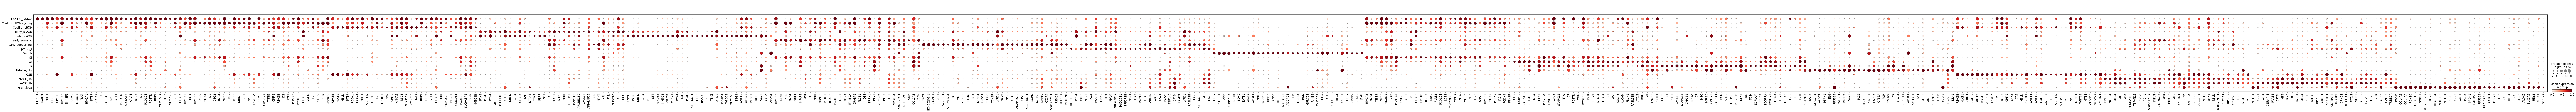

In [16]:
sc.pl.dotplot(adata, list(topgenes_tfIDF), groupby='celltype', standard_scale = 'var', save='_human_somatic_TFIDF.pdf')#topgenes_tfIDF

### DEGs

In [17]:
%%R -o DEGs

library(Seurat)
so = as.Seurat(adataDown, counts = "X", data = "X")
Idents(so) = so$celltype

# Normalize
so <- NormalizeData(so, normalization.method = "LogNormalize", scale.factor = 10000)
so <- ScaleData(so, features = rownames(so))

# Extract DEGs for each cell_type
DEGs <- FindAllMarkers(so, 
                       verbose = F, 
                       only.pos = T, 
                       random.seed = 1, 
                       logfc.threshold = 0, 
                       min.pct = 0, 
                       return.thresh = 1)


In [18]:
DEGs.to_csv(path_to_gonads+'/FCA-gonad_somatic_DEGs.tsv', index=False, sep='\t')

### TF activities - Dorothea

In [19]:
%%R 
source('utils/G_lib_TFacts.r')

Joining, by = "cell"
`summarise()` has grouped output by 'tf'. You can override using the `.groups` argument.
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~07m 52s       |++                                                | 2 % ~07m 36s       |++                                                | 3 % ~07m 23s       |+++                                               | 4 % ~07m 17s       |+++                                               | 5 % ~07m 20s       |++++                                              | 6 % ~07m 15s       |++++                                              | 7 % ~07m 14s       |+++++                                             | 8 % ~07m 19s       |+++++                                             | 9 % ~07m 29s       |++++++                                            | 10% ~07m 22s       |++++++                                            | 11% ~07m 14s       |+++++++                

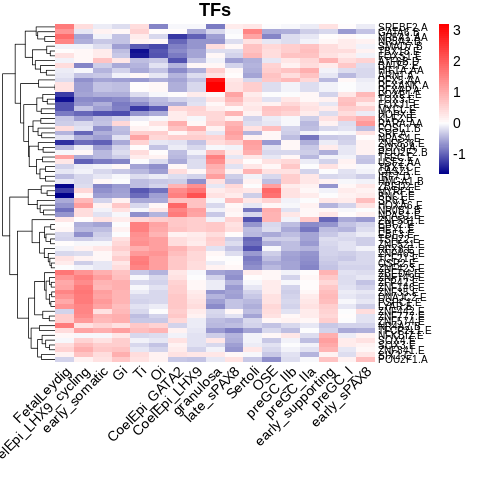

In [20]:
%%R -o df_TFact

# Run Dorothea/viper to get TF activity scores with our custom dorothea_regulon
# Remember "so" should be  normalized
anndataO_doro <- run_viper(so, dorothea_regulon,  options = list(method = "scale", minsize = 4, eset.filter = FALSE, cores = 1, verbose = F))
anndataO_doro

# Get cl x Tf matrix - zscores average
DefaultAssay(object = anndataO_doro) <- "dorothea"
anndataO_doro <- ScaleData(anndataO_doro)
get_TFact_cluster(anndataO_doro, outfile = 'human_somatic_TFact_percluster.csv')


# Use FindAllMarkers to estimate differentially activated TFs
# Make sure you use scaled data
anndataO_doro@assays$dorothea@data = anndataO_doro@assays$dorothea@scale.data
suppressWarnings(df_TFact <- FindAllMarkers(anndataO_doro, 
                                            verbose = F, 
                                            only.pos = F, random.seed = 1, 
                                            logfc.threshold = 0, min.pct = 0, return.thresh = 1,
                                            slot = "data"))
if(is.null(df_TFact$avg_logFC))
    names(df_TFact)[ names(df_TFact) == 'avg_logFC'] = 'avg_logFC'
df_TFact = df_TFact[ order(df_TFact$p_val_adj, decreasing = F),  ]

plot_TFactivities(df_TFact, anndataO_doro, outfile = 'human_somatic_TFact.pdf')

In [21]:
df_TFact.to_csv(path_to_gonads+'/FCA_somatic_TFact.tsv', index=False, sep='\t')

## Early somatic celltypes - markers 

In [22]:
import anndata
XX = adata[[ i in ["G1"] for i in adata.obs.phase ]]
XX = XX[[i < 8.6  for i in XX.obs.PCW]]
XX = XX[[ i not in ['FetalLeydig', 'OSE', 'preGC_IIa', 'preGC_IIb', 'late_sPAX8', 'Ti', 'Oi']  for i in XX.obs.celltype ]]
sc.pp.filter_cells(XX, min_genes=2000)

adataDown = sc.pp.subsample(XX, fraction=0.25, random_state=0, copy=True)
sc.pp.filter_genes(adataDown, min_cells=3)

Trying to set attribute `.obs` of view, copying.


In [23]:
import rpy2.rinterface_lib.callbacks
import logging
# Itoliste R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [24]:
adataDown.X = adataDown.X.toarray()

idx = ['n_genes', 'sample', 'donor', 'location', 'stage', 'sex', 'study', 'batch_collection', 'enrichment', 'cryopreserved', 'TP', '10xKit', 'dig_protocol', 'percent_mito', 'n_counts', 'batch', 'low_ncounts', 'high_mito', 'low_ncounts_high_mito', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'lineages_v1', 'celltype_v1', 'lineage_v2', 'somatic_celltype_v2', 'PCW', 'sample_source', 'trimester', 'lineage', 'celltype_somaticEarly', 'celltype_v2', 'leiden', 'leiden_R']
for i in idx:
    del adataDown.obs[i]
    
adataDown.obs['celltype'] = adataDown.obs['celltype'].astype(str)

del adataDown.obsm['X_scVI']
del adataDown.obsm['X_umap']
del adataDown.obsp['connectivities']
del adataDown.obsp['distances']
del adataDown.uns

In [25]:
%%R -i adataDown
adataDown

class: SingleCellExperiment 
dim: 19693 2568 
metadata(0):
assays(1): X
rownames(19693): A1BG A1BG-AS1 ... ZYX ZZEF1
rowData names(223): gene_ids.0 feature_types.0 ... variances_norm
  n_counts
colnames(2568): HCA_F_GON10828902_GCTCTGTCACAAGTAA
  HCA_F_GON10828901_AAGCCGCAGGGTGTGT ...
  HCA_F_GON10941969_CACTCCATCCTTCAAT HCA_F_GON10941968_TTTGGTTTCACAAACC
colData names(2): celltype celltype2
reducedDimNames(0):
altExpNames(0):


### TF-IDF

In [26]:
%%R -o df_tfIDF -o topgenes_tfIDF

library(Seurat)
library(SoupX)
library(dplyr)
seurat_andata = as.Seurat(adataDown, counts = "X", data = "X")
Idents(seurat_andata) = seurat_andata$celltype


df_tfIDF = quickMarkers(toc = seurat_andata@assays$RNA@counts, clusters = Idents(seurat_andata), N = 500)

df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(Idents(seurat_andata)) )
topgenes_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 30L)$gene) %>%
  unlist(.)

In [27]:
df_tfIDF.to_csv(path_to_gonads+'/FCA_somaticEarly_TFIDF.tsv', index=False, sep='\t')

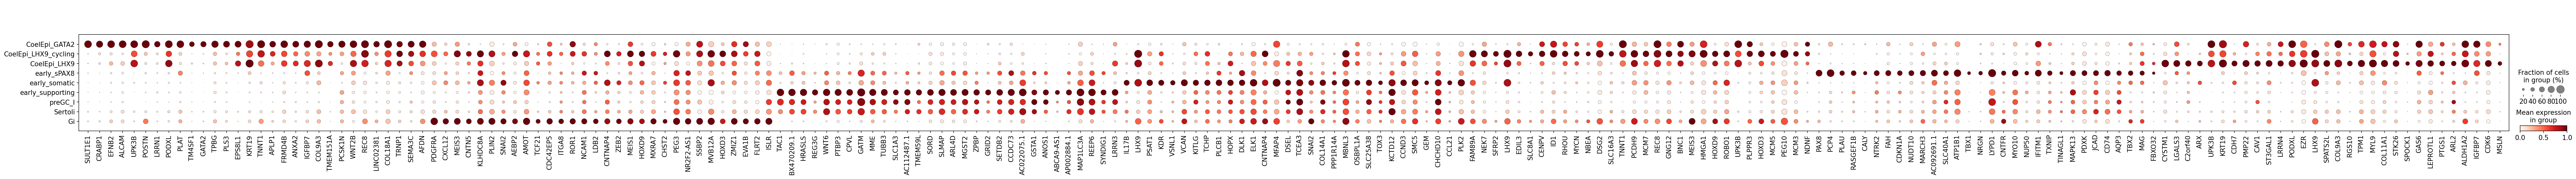

In [28]:
sc.pl.dotplot(XX, list(topgenes_tfIDF), groupby='celltype', standard_scale = 'var', save='_somaticEarly_TFIDF.pdf')#topgenes_tfIDF

### DEGs

In [29]:
%%R -o DEGs

library(Seurat)
so = as.Seurat(adataDown, counts = "X", data = "X")
Idents(so) = so$celltype

# Normalize
so <- NormalizeData(so, normalization.method = "LogNormalize", scale.factor = 10000)
so <- ScaleData(so, features = rownames(so))

# Extract DEGs for each cell_type
DEGs <- FindAllMarkers(so, 
                       test.use = 'LR', 
                       verbose = F, 
                       only.pos = T, 
                       random.seed = 1, 
                       logfc.threshold = 0.2, 
                       min.pct = 0.1, 
                       return.thresh = 0.05)


In [30]:
DEGs.to_csv(path_to_gonads+'/FCA-gonad_somaticEarly_DEGs.tsv', index=False, sep='\t')

### TF activities - Dorothea

In [31]:
%%R 
source('utils/G_lib_TFacts.r')

Joining, by = "cell"
`summarise()` has grouped output by 'tf'. You can override using the `.groups` argument.
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~13s           |++                                                | 2 % ~13s           |++                                                | 3 % ~14s           |+++                                               | 4 % ~13s           |+++                                               | 5 % ~13s           |++++                                              | 6 % ~13s           |++++                                              | 7 % ~13s           |+++++                                             | 8 % ~13s           |+++++                                             | 9 % ~13s           |++++++                                            | 10% ~13s           |++++++                                            | 11% ~13s           |+++++++                

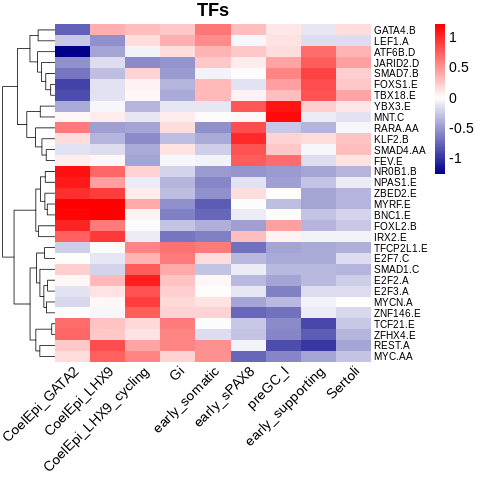

In [32]:
%%R -o df_TFact

# Run Dorothea/viper to get TF activity scores with our custom dorothea_regulon
# Remember "so" should be  normalized
anndataO_doro <- run_viper(so, dorothea_regulon,  options = list(method = "scale", minsize = 4, eset.filter = FALSE, cores = 1, verbose = F))
anndataO_doro

# Get cl x Tf matrix - zscores average
DefaultAssay(object = anndataO_doro) <- "dorothea"
anndataO_doro <- ScaleData(anndataO_doro)
get_TFact_cluster(anndataO_doro, outfile = 'somaticEarly_TFact_percluster.csv')


# Use FindAllMarkers to estimate differentially activated TFs
# Make sure you use scaled data
anndataO_doro@assays$dorothea@data = anndataO_doro@assays$dorothea@scale.data
suppressWarnings(df_TFact <- FindAllMarkers(anndataO_doro, test.use = 'LR', verbose = F, 
                                            only.pos = F, random.seed = 1, logfc.threshold = 0, min.pct = 0, return.thresh = 1,
                                            slot = "data"))
if(is.null(df_TFact$avg_logFC))
    names(df_TFact)[ names(df_TFact) == 'avg_logFC'] = 'avg_logFC'
df_TFact = df_TFact[ order(df_TFact$p_val_adj, decreasing = F),  ]

plot_TFactivities(df_TFact, anndataO_doro, outfile = 'somaticEarly_TFact.pdf')

In [33]:
df_TFact.to_csv(path_to_gonads+'/FCA_somaticEarly_TFact.tsv', index=False, sep='\t')

## Ovarian somatic celltypes - markers 

In [10]:
import anndata
XX = adata[[ i in ["G1"] for i in adata.obs.phase ]]
XX = XX[['female' in i  for i in XX.obs.sex]]
XX = XX[[ i in ['CoelEpi_LHX9', 'early_somatic', 'early_supporting', 'early_sPAX8', 'preGC_I',  'OSE', 'preGC_IIa', 'preGC_IIb','granulosa']  for i in XX.obs.celltype ]]

sc.pp.filter_cells(XX, min_genes=1000)
sc.pp.filter_genes(XX, min_cells=3)

XX.obs['celltype'].value_counts()

Trying to set attribute `.obs` of view, copying.


preGC_IIb           23016
preGC_I             14678
preGC_IIa           12181
OSE                  5690
early_supporting     5287
early_sPAX8          2806
CoelEpi_LHX9         2385
early_somatic        1253
granulosa             362
Name: celltype, dtype: int64

In [11]:
#  Downsample to the smallest pop size
target_cells = 400
XX.obs['celltype'].value_counts()

XX.obs['cell'] = XX.obs.index
adatas = [XX[XX.obs['celltype'].isin([cl])] for cl in XX.obs['celltype'].cat.categories]

for dat in adatas:
    if dat.n_obs > target_cells:
        sc.pp.subsample(dat, n_obs=target_cells, random_state=0)
adata_downsampled = adatas[0].concatenate(*adatas[1:])
adataDown = XX[[ i in adata_downsampled.obs.cell.tolist() for i in XX.obs['cell'] ]]

sc.pp.filter_genes(adataDown, min_cells=20)
adataDown.obs['celltype'].value_counts()

Trying to set attribute `.var` of view, copying.


preGC_IIb           400
preGC_IIa           400
OSE                 400
preGC_I             400
early_supporting    400
early_somatic       400
early_sPAX8         400
CoelEpi_LHX9        400
granulosa           362
Name: celltype, dtype: int64

In [12]:
import rpy2.rinterface_lib.callbacks
import logging
# Itoliste R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython


In [13]:
adataDown.X = adataDown.X.toarray()

idx = ['n_genes', 'sample', 'donor', 'location', 'stage', 'sex', 'study', 'batch_collection', 'enrichment', 'cryopreserved', 'TP', '10xKit', 'dig_protocol', 'percent_mito', 'n_counts', 'batch', 'low_ncounts', 'high_mito', 'low_ncounts_high_mito', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'lineages_v1', 'celltype_v1', 'lineage_v2', 'somatic_celltype_v2', 'PCW', 'sample_source', 'trimester', 'lineage', 'celltype_somaticEarly', 'celltype_v2', 'leiden', 'leiden_R']
for i in idx:
    del adataDown.obs[i]
    
adataDown.obs['celltype'] = adataDown.obs['celltype'].astype(str)

del adataDown.obsm['X_scVI']
del adataDown.obsm['X_umap']
del adataDown.obsp['connectivities']
del adataDown.obsp['distances']
del adataDown.uns

In [14]:
%%R -i adataDown
adataDown

class: SingleCellExperiment 
dim: 15864 3562 
metadata(0):
assays(1): X
rownames(15864): A1BG A1BG-AS1 ... ZYX ZZEF1
rowData names(223): gene_ids.0 feature_types.0 ... variances_norm
  n_counts
colnames(3562): FCA_GND8047885_AAAGATGTCCGAACGC
  FCA_GND8047885_AAATGCCGTAGGAGTC ...
  HCA_F_GON10941969_TTTGCGCTCGTCACGG HCA_F_GON10941969_TTTGTCAAGGCTCTTA
colData names(3): celltype celltype2 cell
reducedDimNames(0):
altExpNames(0):


### TF-IDF

In [15]:
%%R -o df_tfIDF -o topgenes_tfIDF

library(Seurat)
library(SoupX)
library(dplyr)
seurat_andata = as.Seurat(adataDown, counts = "X", data = "X")
Idents(seurat_andata) = seurat_andata$celltype


df_tfIDF = quickMarkers(toc = seurat_andata@assays$RNA@counts, clusters = Idents(seurat_andata), N = 500)

df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(Idents(seurat_andata)) )
topgenes_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 30L)$gene) %>%
  unlist(.)

In [16]:
df_tfIDF.to_csv(path_to_gonads+'/FCA_somaticOvary_with_PAX8_TFIDF.tsv', index=False, sep='\t')

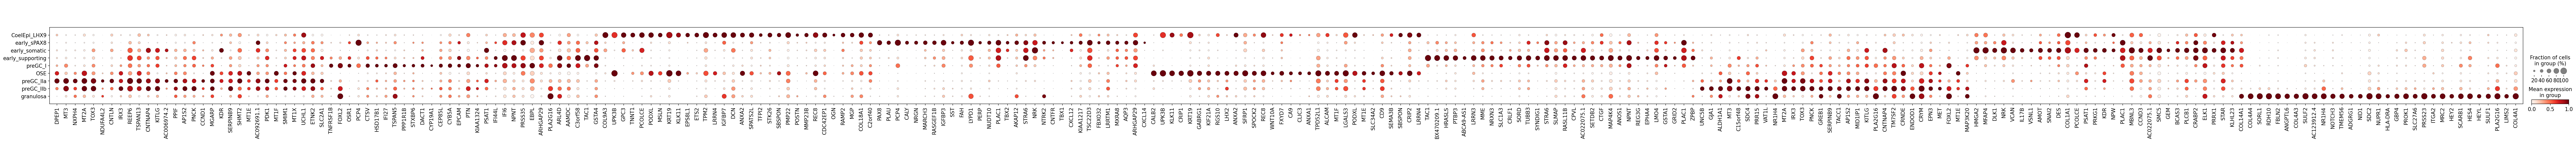

In [17]:
sc.pl.dotplot(XX, list(topgenes_tfIDF), groupby='celltype', standard_scale = 'var', save='_somaticOvary_TFIDF.pdf')#topgenes_tfIDF

### DEGs

In [18]:
%%R -o DEGs

library(Seurat)
so = as.Seurat(adataDown, counts = "X", data = "X")
Idents(so) = so$celltype

# Normalize
so <- NormalizeData(so, normalization.method = "LogNormalize", scale.factor = 10000)
so <- ScaleData(so, features = rownames(so))

# Extract DEGs for each cell_type
DEGs <- FindAllMarkers(so, 
                       verbose = F, 
                       only.pos = T, 
                       random.seed = 1, 
                       logfc.threshold = 0, 
                       min.pct = 0, 
                       return.thresh = 1)

In [19]:
DEGs.to_csv(path_to_gonads+'/FCA-gonad_somaticOvary_with_PAX8_DEGs.tsv', index=False, sep='\t')

### TF activities - Dorothea

In [20]:
%%R 
source('utils/G_lib_TFacts.r')

Joining, by = "cell"
`summarise()` has grouped output by 'tf'. You can override using the `.groups` argument.
Joining, by = "cell"
`summarise()` has grouped output by 'tf'. You can override using the `.groups` argument.


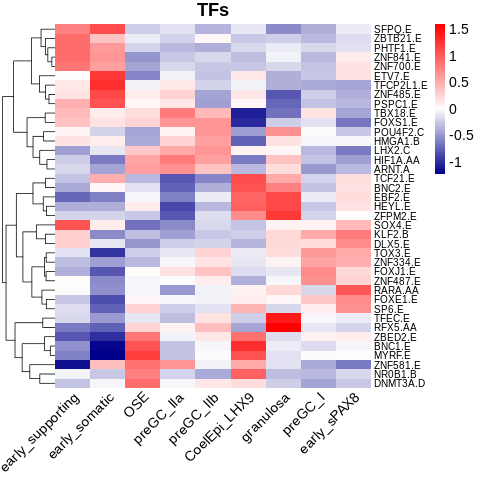

In [21]:
%%R -o df_TFact

# Run Dorothea/viper to get TF activity scores with our custom dorothea_regulon
# Remember "so" should be  normalized
anndataO_doro <- run_viper(so, dorothea_regulon,  options = list(method = "scale", minsize = 4, eset.filter = FALSE, cores = 1, verbose = F))
anndataO_doro

# Get cl x Tf matrix - zscores average
DefaultAssay(object = anndataO_doro) <- "dorothea"
anndataO_doro <- ScaleData(anndataO_doro)
get_TFact_cluster(anndataO_doro, outfile = 'somaticOvary_TFact_percluster.csv')


# Use FindAllMarkers to estimate differentially activated TFs
# Make sure you use scaled data
anndataO_doro@assays$dorothea@data = anndataO_doro@assays$dorothea@scale.data
suppressWarnings(df_TFact <- FindAllMarkers(anndataO_doro, 
                                            verbose = F, 
                                            only.pos = F, random.seed = 1, logfc.threshold = 0, min.pct = 0, return.thresh = 1,
                                            slot = "data"))
if(is.null(df_TFact$avg_logFC))
    names(df_TFact)[ names(df_TFact) == 'avg_logFC'] = 'avg_logFC'
df_TFact = df_TFact[ order(df_TFact$p_val_adj, decreasing = F),  ]

plot_TFactivities(df_TFact, anndataO_doro, outfile = 'somaticOvary_TFact.pdf')

In [22]:
df_TFact.to_csv(path_to_gonads+'/FCA_somaticOvary_with_PAX8_TFact.tsv', index=False, sep='\t')

# Sexually dimorphic genes in early somatic

## Identify recurrent sexually dimorphic genes 

Unbiased identification of recurrent sexually dimorphic genes by doing DEG analysis in all somatic populations.
We need these genes to removed them as these are non-population specific.

In [34]:
import anndata
XX = adata[[ i in ["G1"] for i in adata.obs.phase ]]
XX = XX[[ i in ['CoelEpi_LHX9', 'Gi', 'early_somatic', 'early_supporting', 'early_sPAX8']  for i in XX.obs.celltype ]]
adataDown_ES = XX[[ float(i) <= 8 for i in XX.obs.PCW ]]

sc.pp.filter_cells(adataDown_ES, min_genes=1000)
adataDown_ES.obs['celltype'].value_counts()

Trying to set attribute `.obs` of view, copying.


early_supporting    2774
Gi                  2210
early_somatic       1180
early_sPAX8          852
CoelEpi_LHX9         570
Name: celltype, dtype: int64

In [35]:
#  Downsample to the smallest pop size
target_cells = 500

adataDown_ES.obs['cell'] = adataDown_ES.obs.index
adatas = [adataDown_ES[adataDown_ES.obs['celltype'].isin([cl])] for cl in adataDown_ES.obs['celltype'].cat.categories]

for dat in adatas:
    if dat.n_obs > target_cells:
        sc.pp.subsample(dat, n_obs=target_cells, random_state=0)
adata_downsampled = adatas[0].concatenate(*adatas[1:])
adataDown_ES = adataDown_ES[[ i in adata_downsampled.obs.cell.tolist() for i in adataDown_ES.obs['cell'] ]]

sc.pp.filter_genes(adataDown_ES, min_cells=20)

Trying to set attribute `.var` of view, copying.


In [36]:
# clean up andata for R
adataDown_ES.X = adataDown_ES.X.toarray()

idx = ['n_genes', 'sample', 'donor', 'location', 'stage', 'study', 'batch_collection', 'enrichment', 'cryopreserved', 'TP', '10xKit', 'dig_protocol', 'percent_mito', 'n_counts', 'batch', 'low_ncounts', 'high_mito', 'low_ncounts_high_mito', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'lineages_v1', 'celltype_v1', 'lineage_v2', 'somatic_celltype_v2', 'PCW', 'sample_source', 'trimester', 'lineage', 'celltype_somaticEarly', 'celltype_v2', 'leiden', 'leiden_R']
for i in idx:
    del adataDown_ES.obs[i]
    
adataDown_ES.obs['celltype'] = adataDown_ES.obs['celltype'].astype(str)

del adataDown_ES.obsm['X_scVI']
del adataDown_ES.obsm['X_umap']
del adataDown_ES.obsp['connectivities']
del adataDown_ES.obsp['distances']
del adataDown_ES.uns

In [37]:
%%R -i adataDown_ES
adataDown_ES

class: SingleCellExperiment 
dim: 14985 2500 
metadata(0):
assays(1): X
rownames(14985): A1BG A1BG-AS1 ... ZYX ZZEF1
rowData names(223): gene_ids.0 feature_types.0 ... variances_norm
  n_counts
colnames(2500): FCA_GND8125923_AAACCTGAGTGTGGCA
  FCA_GND8125923_AAACGGGAGCCAGAAC ...
  HCA_F_GON10941969_TTTGCGCTCGTCACGG HCA_F_GON10941969_TTTGTCAAGGCTCTTA
colData names(4): sex celltype celltype2 cell
reducedDimNames(0):
altExpNames(0):


In [38]:
%%R -o DEGs

library(Seurat)
so = as.Seurat(adataDown_ES, counts = "X", data = "X")
Idents(so) = so$sex

# Normalize
so <- NormalizeData(so, normalization.method = "LogNormalize", scale.factor = 10000)
so <- ScaleData(so, features = rownames(so))


# Extract DEGs for each cell_type
for (cl in unique(so$celltype) ){
    print(cl)
    so_cl =  subset(so, cells = colnames(so)[ so$celltype == cl ] )
    DEGs <- FindAllMarkers(so_cl, 
                           verbose = F, 
                           only.pos = T, 
                           random.seed = 1, 
                           logfc.threshold = 0.1, 
                           min.pct = 0.1, 
                           return.thresh = 1)
    DEGs = DEGs[ order(DEGs$avg_logFC, decreasing=T) , ]
    write.csv(DEGs, file = paste0('human_sexDim_',cl,'.csv'), quote = F, row.names = F)
}

[1] "CoelEpi_LHX9"
[1] "early_sPAX8"
[1] "early_somatic"
[1] "early_supporting"
[1] "Gi"


In [39]:
%%R -o sex_genes

sex_genes = list()
for( cl in c('CoelEpi_LHX9', 'Gi', 'early_somatic', 'early_supporting', 'early_sPAX8') ){
    df = read.csv(paste0('human_sexDim_',cl,'.csv'), stringsAsFactors = F)
    sex_genes[[cl]] = subset(df, p_val < 0.05)$gene
}
sex_genes = Reduce(intersect, sex_genes)
all(c('XIST', 'RPS4Y1', 'EIF1AY', 'DDX3Y', 'GSTM1') %in% sex_genes)
sex_genes

  [1] "RPS4Y1"     "AL138963.3" "XIST"       "GSTM1"      "MSMO1"     
  [6] "HIST1H1E"   "AFDN"       "MCL1"       "TAF10"      "BOD1L1"    
 [11] "CDK2AP1"    "EIF1AY"     "ALYREF"     "PPP1R14B"   "CDON"      
 [16] "ZFPM2"      "UBALD2"     "PPP1R10"    "PHC2"       "CD81"      
 [21] "MXRA7"      "UTY"        "DDX3Y"      "TNRC6B"     "RBM23"     
 [26] "NDUFA11"    "E2F5"       "CAMK2N1"    "NPTN"       "AC007952.4"
 [31] "CCDC66"     "BCL7C"      "SRSF6"      "DENND4C"    "HIST1H2BC" 
 [36] "GXYLT2"     "HIST1H2AC"  "PCBP2"      "ZNRF1"      "STK24"     
 [41] "VEGFB"      "PON2"       "SUZ12"      "NLGN4Y"     "PRKAR2B"   
 [46] "TIMP2"      "GOLGA4"     "EPS15"      "GNAS"       "HMGB2"     
 [51] "PRRC2B"     "BRK1"       "PEG10"      "EVA1B"      "SDHD"      
 [56] "TCF4"       "KPNA4"      "ZFPM1"      "AHNAK"      "FAM89B"    
 [61] "CKAP5"      "UNC50"      "FAM69B"     "SLC25A32"   "ITPR2"     
 [66] "C4orf3"     "TOB1"       "NFIL3"      "SNHG7"      "HSPA5"     
 [71] 

## Identify sexually dimorphic genes in early_supporting population

Identify genes that are sexually dimorphic only in the early_supporting population at the time of sex specification

In [40]:
import anndata
XX = adata[[ i in ["G1"] for i in adata.obs.phase ]]
XX = XX[[ float(i) < 8 for i in XX.obs.PCW ]]

adataDown_ES = XX[[ i in 'early_supporting' for i in XX.obs.celltype]]
sc.pp.filter_cells(adataDown_ES, min_genes=1000)
adataDown_ES.obs['celltype2'].value_counts()

Trying to set attribute `.obs` of view, copying.


early_supporting_female    723
early_supporting_male      371
Name: celltype2, dtype: int64

In [41]:
#  Downsample to the smallest pop size
target_cells = 371

adataDown_ES.obs['cell'] = adataDown_ES.obs.index
adatas = [adataDown_ES[adataDown_ES.obs['celltype2'].isin([cl])] for cl in adataDown_ES.obs['celltype2'].cat.categories]

for dat in adatas:
    if dat.n_obs > target_cells:
        sc.pp.subsample(dat, n_obs=target_cells, random_state=0)
adata_downsampled = adatas[0].concatenate(*adatas[1:])
adataDown_ES = adataDown_ES[[ i in adata_downsampled.obs.cell.tolist() for i in adataDown_ES.obs['cell'] ]]

sc.pp.filter_genes(adataDown_ES, min_cells=20)

Trying to set attribute `.var` of view, copying.


In [42]:
# clean up andata for R
adataDown_ES.X = adataDown_ES.X.toarray()

idx = ['n_genes', 'sample', 'donor', 'location', 'stage', 'sex', 'study', 'batch_collection', 'enrichment', 'cryopreserved', 'TP', '10xKit', 'dig_protocol', 'percent_mito', 'n_counts', 'batch', 'low_ncounts', 'high_mito', 'low_ncounts_high_mito', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'lineages_v1', 'celltype_v1', 'lineage_v2', 'somatic_celltype_v2', 'PCW', 'sample_source', 'trimester', 'lineage', 'celltype_somaticEarly', 'celltype_v2', 'leiden', 'leiden_R']
for i in idx:
    del adataDown_ES.obs[i]
    
adataDown_ES.obs['celltype2'] = adataDown_ES.obs['celltype2'].astype(str)

del adataDown_ES.obsm['X_scVI']
del adataDown_ES.obsm['X_umap']
del adataDown_ES.obsp['connectivities']
del adataDown_ES.obsp['distances']
del adataDown_ES.uns

In [43]:
%%R -i adataDown_ES
adataDown_ES

class: SingleCellExperiment 
dim: 11948 742 
metadata(0):
assays(1): X
rownames(11948): A1BG A1BG-AS1 ... ZYX ZZEF1
rowData names(223): gene_ids.0 feature_types.0 ... variances_norm
  n_counts
colnames(742): FCA_GND8125923_AAACCTGGTCTTCGTC
  FCA_GND8125923_AAACGGGGTGAGGGAG ...
  HCA_F_GON10828901_CAGCTAAGTAGAAAGG HCA_F_GON10828902_CATGCCTAGGATGCGT
colData names(3): celltype celltype2 cell
reducedDimNames(0):
altExpNames(0):


In [44]:
%%R -o DEGs

library(Seurat)
so = as.Seurat(adataDown_ES, counts = "X", data = "X")
Idents(so) = so$celltype2

# Normalize
so <- NormalizeData(so, normalization.method = "LogNormalize", scale.factor = 10000)
so <- ScaleData(so, features = rownames(so))

# Extract DEGs for each cell_type
DEGs <- FindAllMarkers(so, 
#                        test.use = 'LR', 
                       verbose = F, 
                       only.pos = T, 
                       random.seed = 1, 
                       logfc.threshold = 0.01, 
                       min.pct = 0.1, 
                       return.thresh = 1)

DEGs = DEGs[ order(DEGs$avg_logFC, decreasing=T) , ]

In [45]:
DEGs.head(20)

p_val  avg_logFC  pct.1  pct.2      p_val_adj  \
RPS4Y1     2.141230e-138   2.204393  0.992  0.000  2.558341e-134   
IGFBP2      2.228834e-88   1.240700  0.895  0.375   2.663011e-84   
XIST        1.139015e-93   1.195143  0.760  0.000   1.360895e-89   
GSTM1       5.052518e-82   1.079928  0.690  0.000   6.036749e-78   
H1FX        9.804579e-80   1.043451  0.892  0.429   1.171451e-75   
TAC1        4.694897e-61   0.970884  0.881  0.364   5.609463e-57   
RELN        2.330489e-68   0.963718  0.755  0.097   2.784468e-64   
LRRN3       3.753837e-47   0.851815  0.763  0.240   4.485084e-43   
SNHG7       2.035066e-48   0.842163  0.728  0.318   2.431497e-44   
RNF187      1.780964e-46   0.829870  0.571  0.105   2.127896e-42   
KLF6        1.588957e-41   0.828090  0.752  0.302   1.898486e-37   
ABCA9-AS1   8.115411e-39   0.826852  0.550  0.105   9.696293e-35   
SLC1A3      1.609414e-38   0.777395  0.539  0.089   1.922928e-34   
MZT2B       2.973286e-62   0.758063  0.876  0.542   3.552483e-58   
PTOV1       1.918556e-92   0.756421  0.965  0.733   2.292290e-88   
SRY         1.891261e-34   0.755217  0.340  0.000   2.259678e-30   
NDN         1.990819e-64   0.745877  0.881  0.577   2.378630e-60   
ACTC1       2.553634e-27   0.742568  0.596  0.210   3.051082e-23   
EIF1AY      1.291668e-36   0.740204  0.358  0.000   1.543284e-32   
DDX3Y       1.291668e-36   0.715298  0.358  0.000   1.543284e-32   

                           cluster       gene  
RPS4Y1       early_supporting_male     RPS4Y1  
IGFBP2       early_supporting_male     IGFBP2  
XIST       early_supporting_female       XIST  
GSTM1      early_supporting_female      GSTM1  
H1FX         early_supporting_male       H1FX  
TAC1       early_supporting_female       TAC1  
RELN       early_supporting_female       RELN  
LRRN3      early_supporting_female      LRRN3  
SNHG7        early_supporting_male      SNHG7  
RNF187       early_supporting_male     RNF187  
KLF6       early_supporting_female       KLF6  
ABCA9-AS1  early_supporting_female  ABCA9-AS1  
SLC1A3     early_supporting_female     SLC1A3  
MZT2B        early_supporting_male      MZT2B  
PTOV1        early_supporting_male      PTOV1  
SRY          early_supporting_male        SRY  
NDN          early_supporting_male        NDN  
ACTC1      early_supporting_female      ACTC1  
EIF1AY       early_supporting_male     EIF1AY  
DDX3Y        early_supporting_male      DDX3Y

In [46]:
DEGs.to_csv(path_to_gonads+'/FCA-gonads_somaticEarly_earlysupporting_DEGs.tsv', index=False, sep='\t')

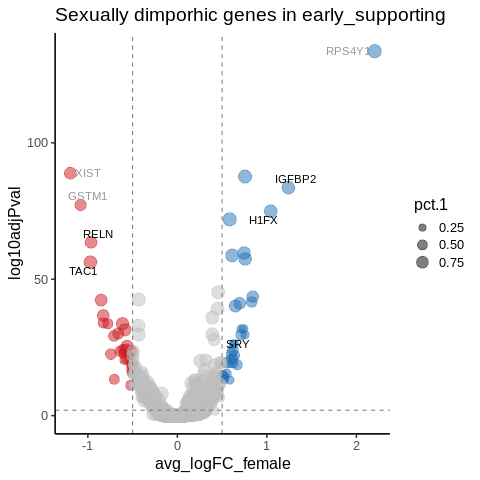

In [47]:
%%R -o DEGs -i path_to_gonads -i sex_genes

sex_genes

library(ggplot2)
library(RColorBrewer)

fe = 'early_supporting_female'
df = DEGs
df = subset(df, ! is.na(gene) )
df = df[ order(df$avg_logFC, decreasing = T) , ]
# DEGs = DEGs[ order(DEGs$p_val_adj, decreasing=F) , ]
df$pctsum = df$pct.1 + df$pct.2
df = subset(df, pctsum < 1.9 )
df$avg_logFC_female = df$avg_logFC
df$avg_logFC_female[ df$cluster == fe ] = -df$avg_logFC[ df$cluster == fe ]
df$log10adjPval = -log10(df$p_val_adj)
df$color = 'grey'
df$color[ df$avg_logFC_female > 0.5 & df$p_val_adj < 0.01] = brewer.pal(n=4, 'Blues')[4]
df$color[ df$avg_logFC_female < -0.5 & df$p_val_adj < 0.01] = brewer.pal(n=4, 'Reds')[4]
n=7
df$label = ''
df$label2 = ''
df$label[ which(df$p_val_adj < 0.01 & abs(df$avg_logFC_female) > 0.5)[1:n] ] = df$gene[ which(df$p_val_adj < 0.01 & abs(df$avg_logFC_female) > 0.5)[1:n] ]
# df$label[ which(df$avg_logFC_female > 0.5 & df$p_val_adj < 0.01)[1:n] ] = df$gene[ which(df$avg_logFC_female > 0.5 & df$p_val_adj < 0.01 )[1:n] ]
# df$label[ which(df$avg_logFC_female < -0.5 & df$p_val_adj < 0.01)[1:n] ] = df$gene[ which(df$avg_logFC_female < -0.5 & df$p_val_adj < 0.01 )[1:n] ]
df$label2[ which( df$label != '' & df$gene %in% sex_genes) ] = df$gene[ which(df$label != '' & df$gene %in% sex_genes)]
df$label[ df$gene %in% sex_genes ] = ''
df$label[ df$gene == 'SRY' ] = 'SRY'
# df$label[ df$gene == 'SOX9'  ] = 'SOX9'
# df$label[ df$gene == 'FOXL2'  ] = 'FOXL2'
# df$label[ df$gene == 'OSR1'] = 'OSR1'
# df$label[ df$gene == 'FST'] = 'FST'


library(ggrepel)
p = ggplot(df, aes(y=log10adjPval, x=avg_logFC_female, color = color, size = pct.1)) + geom_point(alpha=0.5) + 
    scale_color_identity() + theme_classic(16) +
    geom_text_repel(data=df, aes(label=label2), color = 'grey60', size = 4) + 
    geom_text_repel(data=subset(df, label != ''), aes(label=label), color = 'black', size = 4) + 
    geom_hline(yintercept = -log10(0.01), color = 'grey50', linetype = "dashed") +
    geom_vline(xintercept = 0.5, color = 'grey50', linetype = "dashed") +
    geom_vline(xintercept = -0.5, color = 'grey50', linetype = "dashed") +
    ggtitle('Sexually dimporhic genes in early_supporting')
p
ggsave(filename = 'human_earlysupporting_volcanoDEGs.pdf', dpi = 75, height = 6, width = 6)
p

# df[which(df$gene %in% c('SRY','ETV5', 'SOX9',  'FOXL2', 'OSR1')), ]